# 拟合光度数据

本示例演示光度数据拟合的基本步骤。更多信息见文档中的 拟合观测数据 页面 (fitting observational data)。

## 设置

首先我们需要加载观测数据作为一个星系对象，正如示例 2 中所示：

Bagpipes: Latex turned off in rcParams, plots may look strange.
Loading photometry for object ID 17433 (row 17432)
<class 'numpy.ndarray'> (15, 2)


BAGPIPES: Generating IGM absorption table.
Bagpipes: Latex turned off in rcParams, plots may look strange.
Bagpipes: PyMultiNest import failed, fitting will use the Nautilus sampler instead.


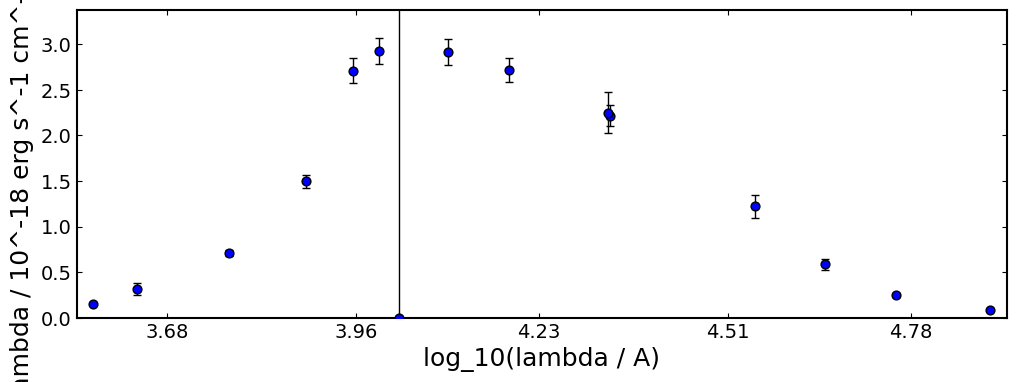

In [ ]:
import numpy as np 
import bagpipes as pipes
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from astropy.io import fits

def load_goodss(ID):
    """ 从 Guo et al. (2013) 目录加载 CANDELS GOODS South 光度数据。 """

    # 从目录中读取相关列。
    cat = np.loadtxt("data/hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt",
                     usecols=(10, 13, 16, 19, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55,
                              11, 14, 17, 20, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56))
    
    
    # 找到目标对象对应的行。
    row = int(ID) - 1
    print(f"Loading photometry for object ID {ID} (row {row})")
    # 从目录中提取该对象。
    fluxes = cat[row, :15]
    
    fluxerrs = cat[row, 15:]

    # 将它们转换为二维数组。
    photometry = np.c_[fluxes, fluxerrs]

    # 将缺失通量的误差设为极大值。
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9*10**99.]
            
    # 对信噪比施加上限：前10个通道最大为20，IRAC通道最大为10。
    for i in range(len(photometry)):
        if i < 10:
            max_snr = 20.
            
        else:
            max_snr = 10.
        
        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr

    print(type(photometry), photometry.shape) # debug
    return  photometry

goodss_filt_list = np.loadtxt("filters/goodss_filt_list.txt", dtype="str")

galaxy = pipes.galaxy("17433", load_goodss, spectrum_exists=False, filt_list=goodss_filt_list) 

fig = galaxy.plot()

In [4]:
photoload = load_goodss("17433")
print(photoload.shape)
print(photoload)

Loading photometry for object ID 17433 (row 17432)
<class 'numpy.ndarray'> (15, 2)
(15, 2)
[[6.987040e-02 7.049980e-03]
 [1.923840e-01 4.059220e-02]
 [8.308090e-01 4.154045e-02]
 [2.950840e+00 1.475420e-01]
 [7.377370e+00 3.688685e-01]
 [9.502210e+00 4.751105e-01]
 [0.000000e+00 9.900000e+99]
 [1.516060e+01 7.580300e-01]
 [2.142950e+01 1.071475e+00]
 [3.460530e+01 1.730265e+00]
 [3.460900e+01 3.460900e+00]
 [5.131500e+01 5.131500e+00]
 [3.950320e+01 3.950320e+00]
 [2.687740e+01 2.687740e+00]
 [1.799710e+01 1.799710e+00]]


## 拟合指示字典

接下来我们需要定义想要拟合数据的模型。我们通过创建一个 拟合指示字典 来实现这一点。在很多方面，它类似于模型组件字典（见示例 1）。但是，它有一些附加选项，用于定义我们想要拟合的参数和下限は想要施加的先验概率。

In [5]:
exp = {}                                  # 指数衰减 (tau) 恒星形成历史组件
exp["age"] = (0.1, 15.)                   # 年龄在 100 Myr 到 15 Gyr 之间变化。实际上
                                          # 代码会自动限制为观测红移处的
                                          # 宇宙年龄。

exp["tau"] = (0.3, 10.)                   # 使 tau 在 300 Myr 到 10 Gyr 之间变化
exp["massformed"] = (1., 15.)             # 使 log10(恒星质量 / M_solar) 在 1 到 15 之间变化
exp["metallicity"] = (0., 2.5)            # 使金属度 Z 在 0 到 2.5 Z_旧太阳 之间变化

dust = {}                                 # 尘埃组件
dust["type"] = "Calzetti"                 # 定义消光曲线的形式
dust["Av"] = (0., 2.)                     # 使消光幅度 Av 在 0 到 2 星等之间变化

fit_instructions = {}                     # 拟合指示字典
fit_instructions["redshift"] = (0., 10.)  # 使观测红移在 0 到 10 之间变化
fit_instructions["exponential"] = exp   
fit_instructions["dust"] = dust
# 👇 添加星云发射参数，避免 fesc 未定义报错 
# fit_instructions["nebular"] = { "logU": -3.0, # 电离参数，可以固定或拟合 "
#                                "fesc": 0.0 }
# 光子逃逸分数，常用默认值是 0.0 

现在可以将星系对象和拟合指示字典传给一个 fit 对象，然后运行 MultiNest 采样器来拟合数据。
注：原官方文档中使用MultiNest采样器。如果你想使用该采样器，请参考readme中的连接来完成安装

In [6]:
fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False, sampler="nautilus") #修改采样器为 nautilus，如果你想使用官方的默认采样器，将sampler参数删除即可


Results loaded from pipes/posterior/./17433.h5

Fitting not performed as results have already been loaded from pipes/posterior/./17433.h5. To start over delete this file or change run.



## 访问后验分布信息

来自拟合参数的后验分布的样本保存在 `fit.posterior.samples` 字典中。默认也会计算一些基本的派生量：

In [7]:
list(fit.posterior.samples)

['dust:Av',
 'exponential:age',
 'exponential:massformed',
 'exponential:metallicity',
 'exponential:tau',
 'redshift',
 'stellar_mass',
 'formed_mass',
 'sfr',
 'ssfr',
 'nsfr',
 'mass_weighted_age',
 'tform',
 'tquench',
 'mass_weighted_zmet',
 'sfh']

所有这些数组的第一个维度都是后验分布中的样本。

如果我们想要执接后验分布中住在恒星质量的中位数，我们可以输入：

In [8]:
print(np.median(fit.posterior.samples["stellar_mass"]))

10.93263935652828


或后验分布中住在恒星形成率的中位数：

In [9]:
print(np.median(np.log10(fit.posterior.samples["sfr"]) - fit.posterior.samples["stellar_mass"]))

-11.575101722625234


或质量于圆感时间的置信区间：

In [10]:
print(np.percentile(fit.posterior.samples["mass_weighted_age"], (16, 84)))

[2.12583496 2.89901505]


In [12]:
print(np.median(fit.posterior.samples["exponential:age"]))

2.7016930641736394


["## \u8fdb\u4e00\u6b65\u7684\u540e\u9a8c\u91cf", "", "\u9ed8\u8ba4\u4e0d\u4f1a\u751f\u6210\u4e0e\u5149\u8c31\u76f8\u5173\u7684\u540e\u9a8c\u91cf\u6837\u672c\uff08\u4f8b\u5982\u5149\u5ea6\u4e0e\u5149\u8c31\u7684\u540e\u9a8c\u9884\u6d4b\u3001\u9휴\u6846 UVJ \u661f\u7b49\uff09\u3002\u53ef\u4ee5\u7528\u4ee5\u4e0b\u65b9\u6cd5\u8ba1\u7b97\uff1a"]

In [22]:
fit.posterior.get_advanced_quantities()
list(fit.posterior.samples)

['dust:Av',
 'exponential:age',
 'exponential:massformed',
 'exponential:metallicity',
 'exponential:tau',
 'redshift',
 'stellar_mass',
 'formed_mass',
 'sfr',
 'ssfr',
 'nsfr',
 'mass_weighted_age',
 'tform',
 'tquench',
 'mass_weighted_zmet',
 'sfh',
 'photometry',
 'spectrum_full',
 'uvj',
 'chisq_phot',
 'dust_curve']

>["\u4fdd\u5b58\u548c\u52a0\u8f7d\u540e\u9a8c\u5206\u5e03", "-----------------------------------", "", "\u5f53\u62df\u5408\u5b8c\u6210\u540e\uff0c\u91cd\u6784\u62df\u5408\u7ed3\u679c\u6240\u9700\u7684\u57fa\u672c\u8f93\u51fa\u4f1a\u4ee5 hdf5 \u6587\u4ef6\u7684\u5f62\u5f0f\u4fdd\u5b58\u5728 \"pipes/posterior\" \u76ee\u5f55\u4e2d\u3002\u5f53\u4f60\u521b\u5efa fit \u5bf9\u8c61\u65f6\uff0c\u5982\u679c\u540e\u9a8c\u5206\u5e03\u6587\u4ef6\u5df2\u7ecf\u5b58\u5728\uff0c\u5b83\u4f1a\u81ea\u52a8\u88ab\u52a0\u8f7d\uff0c\u4f60\u6c38\u8fdc\u65e0\u6cd5\u518d\u4e00\u6b21\u8fd0\u884c fit \u65b9\u6cd5\u3002"]

In [23]:
fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False)


Results loaded from pipes/posterior/./17433.h5

Fitting not performed as results have already been loaded from pipes/posterior/./17433.h5. To start over delete this file or change run.



如果你想重新开始，只需删除后验分布文件。或者，当您创建 fit 对象时，将关键字参数 "run" 设置为一个字符串，这样会启动一个完全全新的拟合，其输出会保存在 pipes/posterior 和 pipes/plots 中与你的运行不名同名的子文根中。

## 诊断图

Bagpipes 允许创建几个标准的诊断图来可视化拟合结果。

默认情况下，所有显示拟合结果的图表都会保存在 "pipes/plots" 目录中。一些情况下我们会改为直接显示。


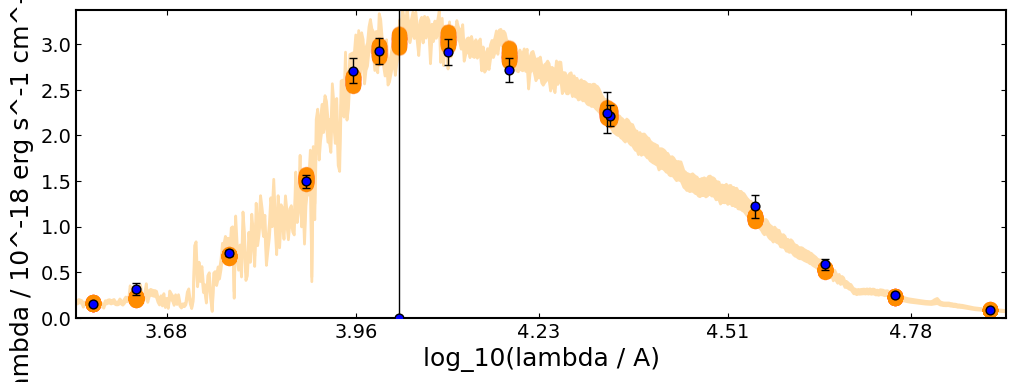

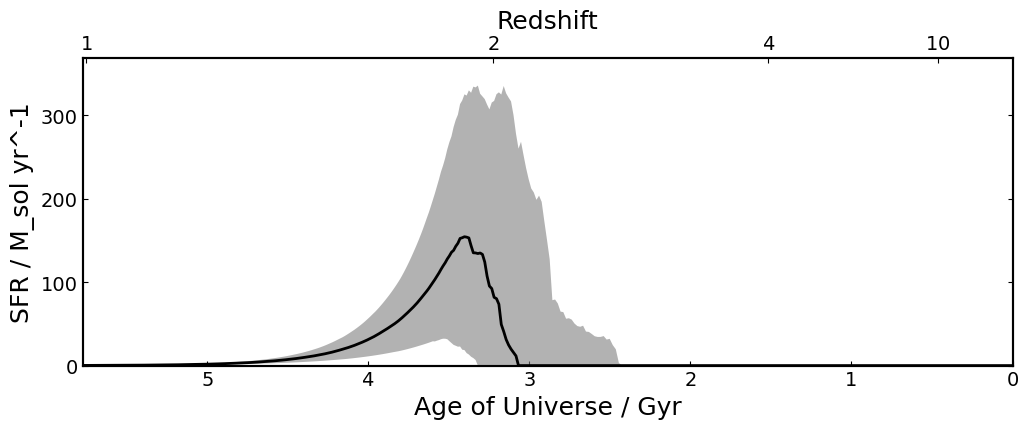

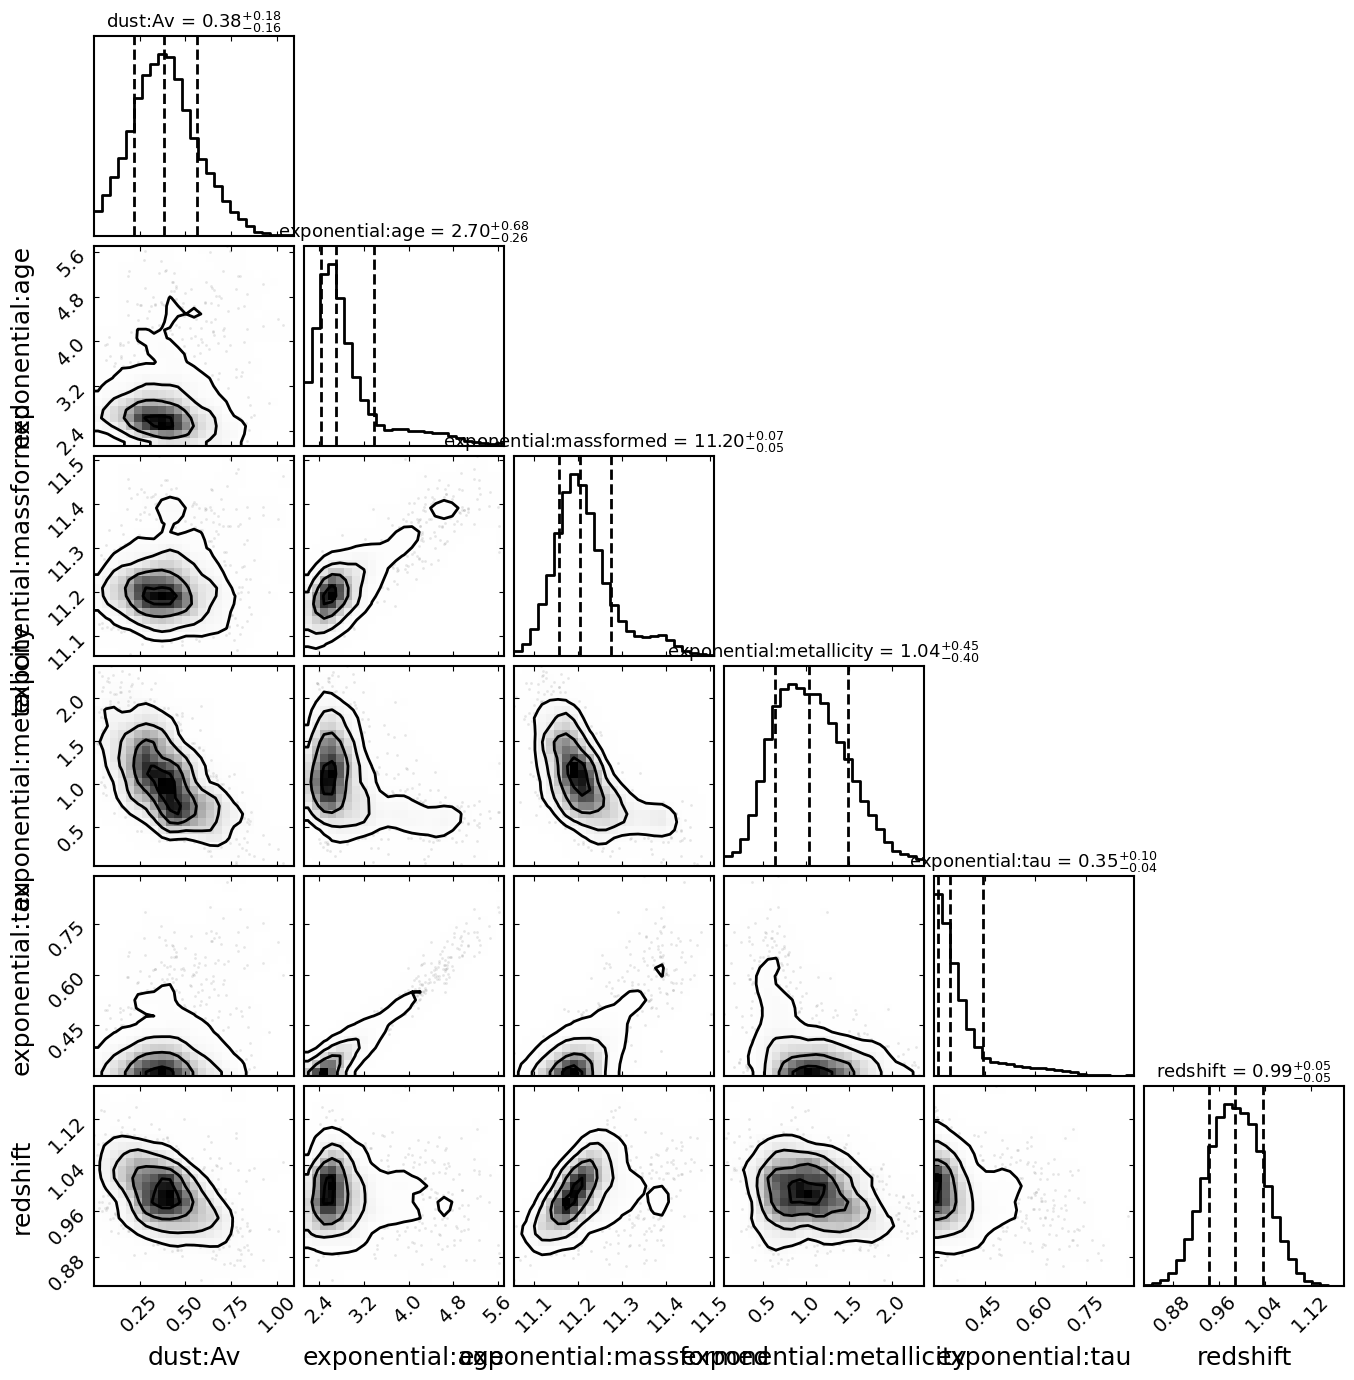

In [24]:
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)
fig = fit.plot_corner(save=False, show=True)

绘图接口设计得関于充分灵活，能够绘制你想看的东西的自定义图表不必上手不脚。自动 LaTeX 轴上标懍也进步做得不错！

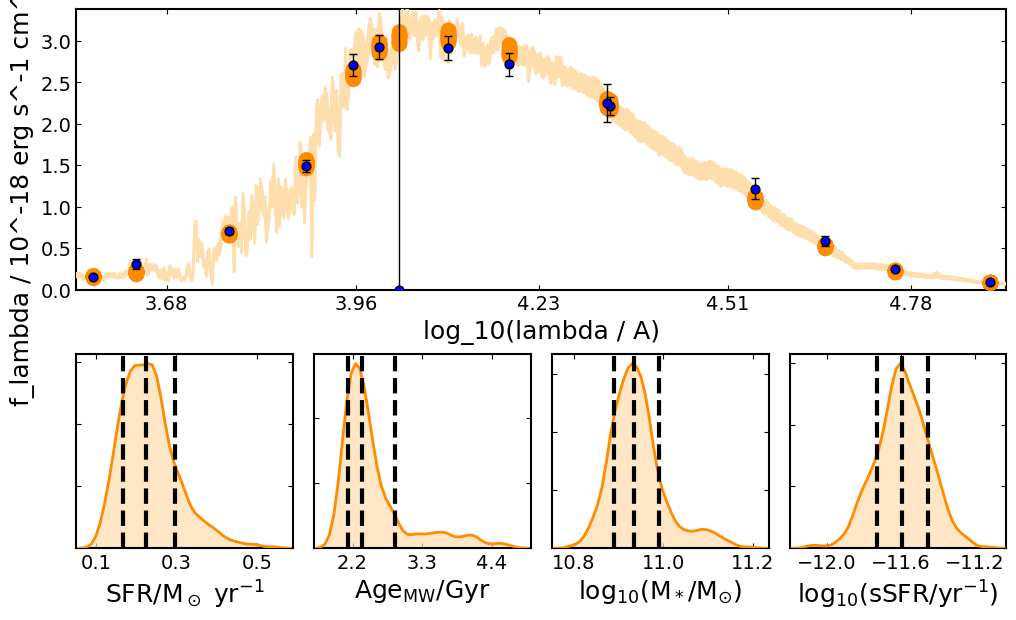

In [25]:
plt.close()

fig = plt.figure(figsize=(12, 7))
gs = mpl.gridspec.GridSpec(7, 4, hspace=3., wspace=0.1)

ax1 = plt.subplot(gs[:4, :])

pipes.plotting.add_observed_photometry(fit.galaxy, ax1, zorder=10)
pipes.plotting.add_photometry_posterior(fit, ax1)

labels = ["sfr", "mass_weighted_age", "stellar_mass", "ssfr"]

post_quantities = dict(zip(labels, [fit.posterior.samples[l] for l in labels]))

axes = []
for i in range(4):
    axes.append(plt.subplot(gs[4:, i]))
    pipes.plotting.hist1d(post_quantities[labels[i]], axes[-1], smooth=True, label=labels[i])

plt.show()

["\u7ee7\u7eed\u4e0b\u4e00\u4e2a\u793a\u4f8b\u4ee5\u4e86\u89e3\u5982\u4f55\u62df\u5408\u66f4\u8fdd\u6742\u7684\u6a21\u578b\uff0c\u5305\u62ec\u5411\u62df\u5408\u53c2\u6570\u5施\u52a0\u5148\u9a8c\u6982\u7387\u3002"]

## MPI 并行化

Bagpipes 支持用 MultiNest 进行拟合的 MPI 并行化。您需要安装 MPI 和 mpi4py 第三方 Python 程序包。然后只需运行 mpirun/mpiexec -n nproc python pythoncode.py， MultiNest 将会自动将多个视释用于可然性计算。